In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import read_dot, graphviz_layout

import utilities.stats as stats
import utilities.graphs as graphs
import utilities.sqlite_helper as helper

In [5]:
# Needs to be done when there are changes in these files ...
import importlib
importlib.reload(helper)
importlib.reload(stats)
importlib.reload(graphs)
print("Updates imports")

Updates imports


TODOS:
[] Failed benchmarks also need to be removed from full graph
[] remove split thing everywhere

#### Helpers

In [6]:
def get_name_from_dot(path):
    # Remove last dot, remove last 3 "_" which are hardcoded
    return path.split("/")[-1].rsplit(".", 1)[0].rsplit("_", 3)[0]

def get_name_from_db_bench(name):
    return name.replace("/", "-")

In [7]:
def change(rl: float, ru: float):
    if ru < 1:
        return (1-ru) * 100
    elif rl > 1:
        return (rl-1) * 100
    else:
        return 0

In [8]:
# Hierachical Bootstrap
def boostrap_ratio_mean_laaber(benchmark: dict, num_iterations: int=10000):
    bootstrap_mean = []
    for _ in range(num_iterations):
        samples = []
        trials = list(benchmark.keys())
        for _ in trials:
            # Pick random trial
            random_trial = np.random.choice(trials, replace=True)
            iterations = list(benchmark[random_trial])
            
            for _ in iterations:
                # Pick random iteration
                random_iteration_idx = np.random.choice(len(iterations), replace=True)
                ns = iterations[random_iteration_idx][2]
                samples.append(ns)

        bootstrap_mean.append(np.mean(samples))  
    return bootstrap_mean          


# Loading Data for instability

In [9]:
db_path_tags = "/Users/christopher/Uni/MasterThesis/experiment_4_roaring/measurements.db"

In [10]:
measurements = helper.get_all_measurements(db_path_tags, start_form_count=1)

# group by tag/version
grouped_by_tag = helper.group_measurements_by_property(measurements, -2)

# group by benchmark name
for tag in grouped_by_tag.keys():
    grouped_by_tag[tag] = helper.group_measurements_by_property(grouped_by_tag[tag], -3)

v1.2.0 BenchmarkChecksum/checksum-1 1.2504794753787867
v1.2.0 BenchmarkChecksum/checksum-1024 0.7369759755678515
v1.2.0 BenchmarkChecksum/checksum-compressed-32768 0.6567045269857351
v1.2.0 BenchmarkChecksum/checksum-16 3.0419847815309775
v1.2.0 BenchmarkChecksum/checksum-compressed-16 0.5991391858828435
v1.2.0 BenchmarkChecksum/checksum-2 0.9018525639033326
v1.2.0 BenchmarkChecksum/checksum-compressed-2 0.9062715231296665
v1.2.0 BenchmarkChecksum/checksum-compressed-262144 1.6878630088980457
v1.2.0 BenchmarkChecksum/checksum-4 0.9512595704686306
v1.2.0 BenchmarkChecksum/checksum-8 0.6491029062447288


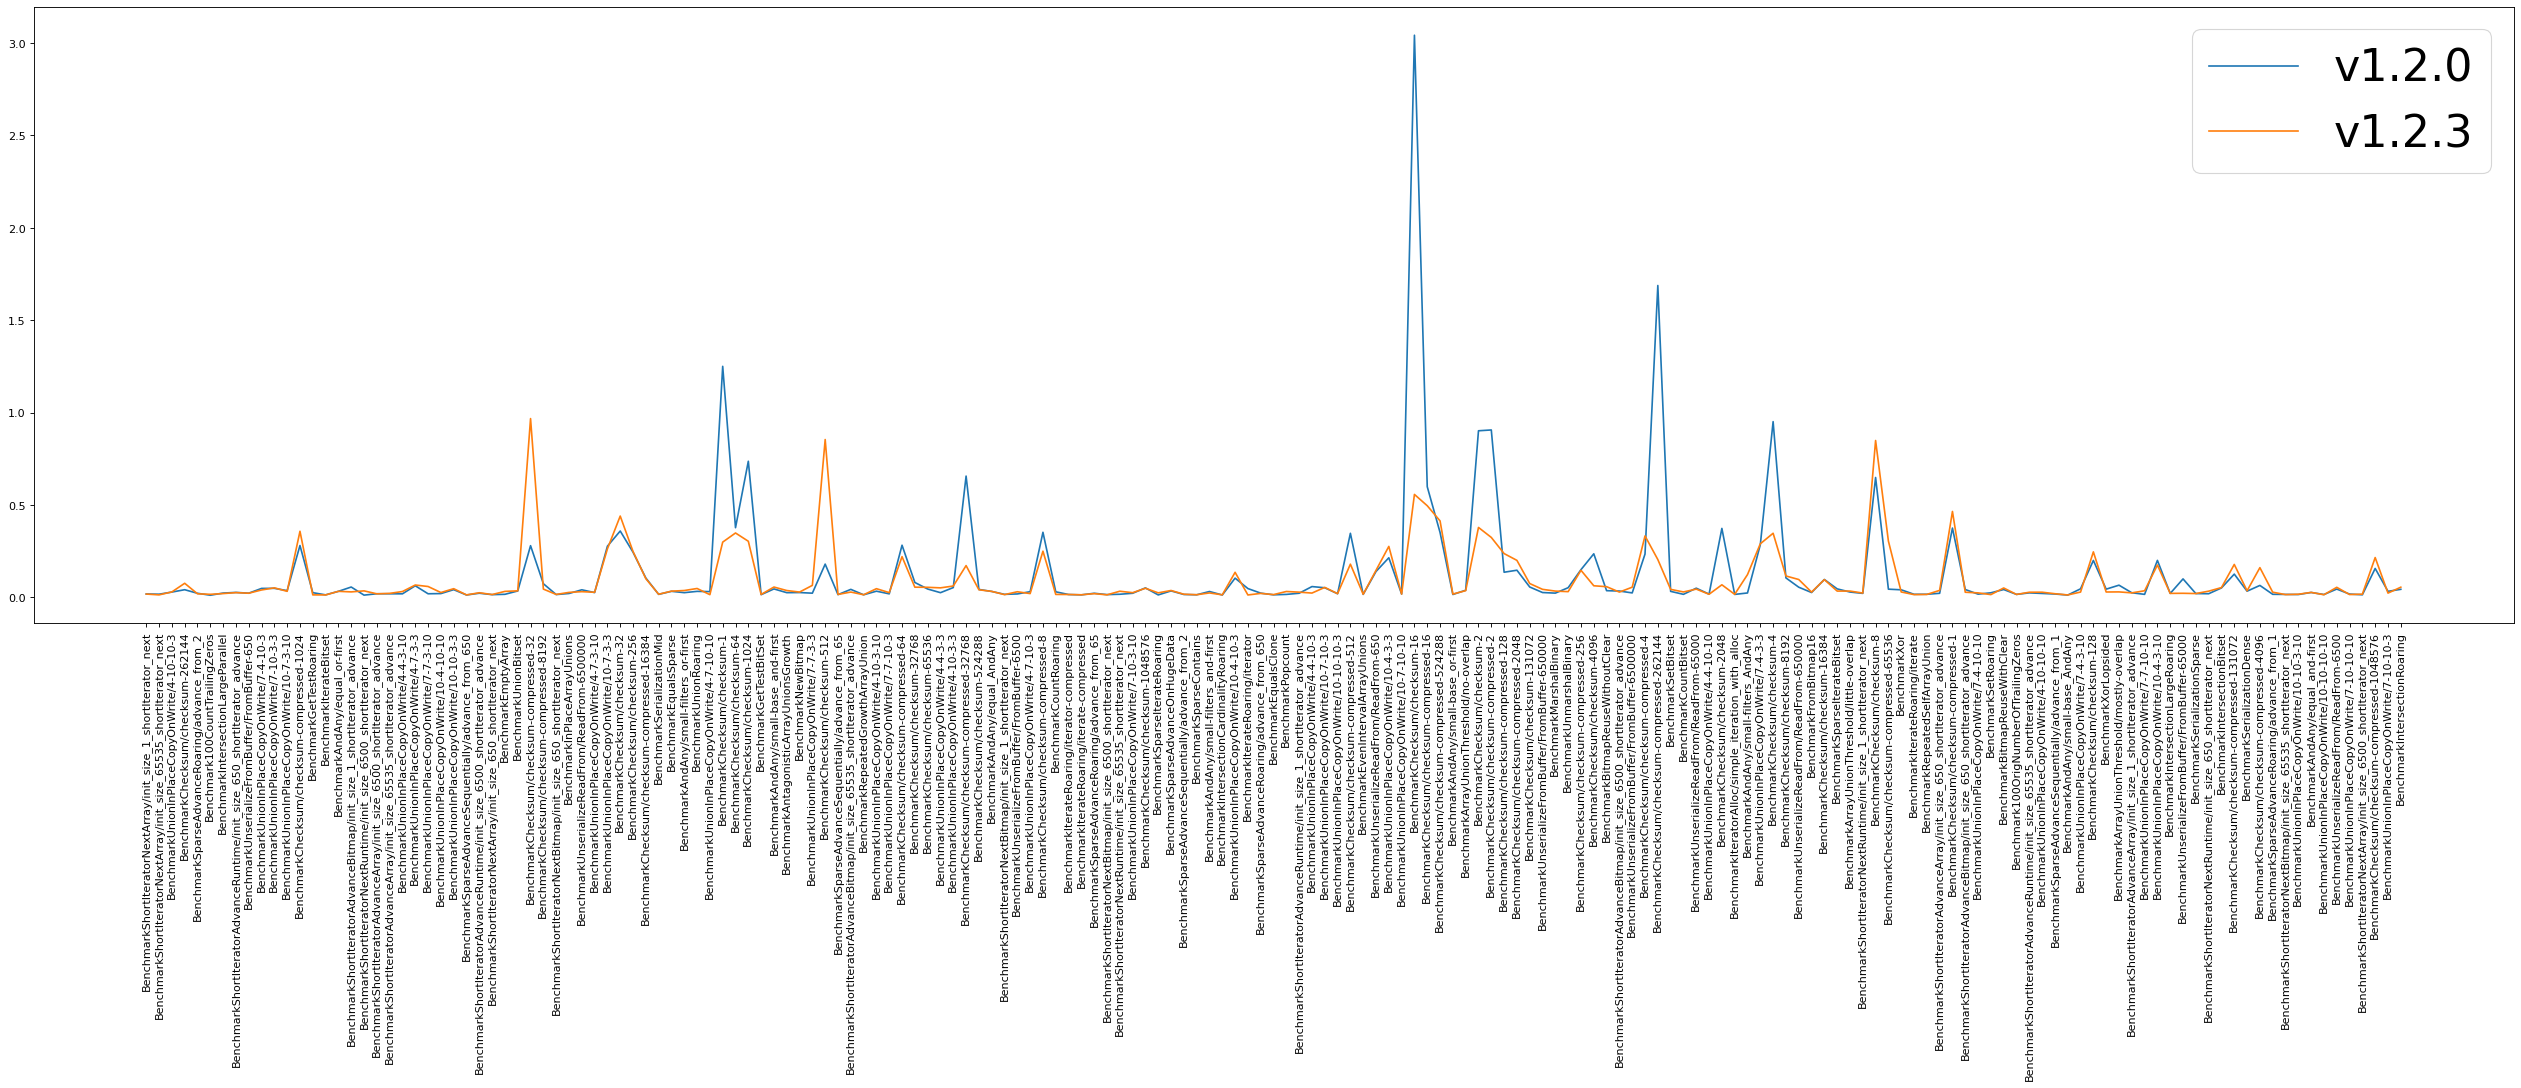

In [11]:
unstable_benchmarks = []
stability_measures = {}

plt.figure(figsize=(40, 10), dpi=80)

labels=list(next(iter(grouped_by_tag.values())).keys())
plt.xticks([x for x in range(len(labels))], labels, rotation='vertical')

for tag in grouped_by_tag.keys():
    cv = []
    spread = []
    for bench in grouped_by_tag[tag].keys():
        x = []
        measurments = grouped_by_tag[tag][bench]
        for entry in measurments:
            x.append(entry[2])
        current_cv = stats.cv(x)
        cv.append(current_cv)
        try:
            stability_measures[get_name_from_db_bench(bench)].append(current_cv)
        except KeyError:
            stability_measures[get_name_from_db_bench(bench)] = [current_cv]

        if (current_cv) > 0.5 and tag == "v1.2.0":
            print(f"{tag} {bench} {current_cv}")
            unstable_benchmarks.append(get_name_from_db_bench(bench))
        spread.append(stats.max_spread(x))

    plt.plot(cv, label=tag)
plt.legend(fontsize="40")
plt.show()

# Calculate Performance Changes

In [13]:
# group by trial
for tag in grouped_by_tag.keys():
    for bench in grouped_by_tag[tag].keys():
        grouped_by_tag[tag][bench] = helper.group_measurements_by_property(grouped_by_tag[tag][bench], -5)

In [14]:
# Increase to 10000
changes = []
for bench in list(grouped_by_tag['v1.2.0'].keys()):
    b_mean_old = boostrap_ratio_mean_laaber(grouped_by_tag['v1.2.0'][bench], 1000)
    b_mean_new = boostrap_ratio_mean_laaber(grouped_by_tag['v1.2.3'][bench], 1000)

    R_B = []
    for i in range(len(b_mean_old)):
        R_B.append(b_mean_new[i] / b_mean_old[i])


    cl = 0.99
    lower_percentile = (1 - cl) / 2
    upper_percentile = 1 - lower_percentile
    lower_bound = np.percentile(R_B, lower_percentile * 100)
    upper_bound = np.percentile(R_B, upper_percentile * 100)
    performance_change = change(lower_bound, upper_bound)
    changes.append(performance_change)

In [16]:
perf_dict = {}
for idx, x in enumerate(changes):
    if x <= 0:
        continue
    name = list(grouped_by_tag['v1.2.0'].keys())[idx]
    name = get_name_from_db_bench(name)
    perf_dict[name] = x

# Load Graph Data

In [17]:
graph_paths0 = "/Users/christopher/Uni/MasterThesis/experiment_4_roaring/instance0/backup-mt-1-instance-0/"
graph_paths1 = "/Users/christopher/Uni/MasterThesis/experiment_4_roaring/instance1/backup-mt-1-instance-1/"

In [18]:
dot_files = []
for graph_paths in [graph_paths0, graph_paths1]:
    # Convert files to dot files for further analysis

    # Clear existing dot files
    for existingDotFile in glob.glob(graph_paths + "*.dot"):
        os.remove(existingDotFile)

    if len(glob.glob(graph_paths + "*.dot")) == 0:
        files = glob.glob(graph_paths + "*")
        for file in files:
            
            if file.endswith(".dot"):
                continue
            
            name = file.split(".out")[0]
            command = f"go tool pprof -nodecount=10000 --nodefraction=0.0 --edgefraction=0.0 -dot {name}.out > {name}.dot"
            stream = os.popen(command)
            output = stream.read()
            

    dot_files.extend(glob.glob(graph_paths + "*.dot"))

In [19]:
"""Load and convert all graphs, and generate a unique node mapping."""
count_bad_input = 0
ordered_graphs = {}
none_perf_benchs = []
removed_node_name = set()
for dot_file in dot_files:
    name = get_name_from_dot(dot_file)

    if "BenchmarkSize" in name or "BenchmarkMemory" in name:
        none_perf_benchs.append(name)
        continue
    
    try:
        curr_graph = read_dot(dot_file)
        curr_graph = graphs.convertWeigthsToFloat(curr_graph)
    except ValueError: 
        count_bad_input += 1
        print(dot_file.split("/")[-1])
        continue
    
    # Check if one of the nodes includes 'runActualBenchmark, if yes create a subgraph starting at that node
    nodes_to_remove = []
    for node in curr_graph.nodes(data=True):
        if  node[1]['label'].startswith('roaring'):
            continue
        nodes_to_remove.append(node[0])
    curr_graph.remove_nodes_from(nodes_to_remove)

    # Add all graphs from the same benchmark together and later form the union
    try: 
        ordered_graphs[name].append(curr_graph)
    except KeyError:
       ordered_graphs[name] = []
       ordered_graphs[name].append(curr_graph)


print(f"Bad input: {count_bad_input}")
print(f"None perf benchmarks: {none_perf_benchs}")
print(f"Removed node names: {removed_node_name}")

Bad input: 0
None perf benchmarks: ['05-28-2023_BenchmarkSizeRoaring', '05-28-2023_BenchmarkMemoryUsage', '05-28-2023_BenchmarkSizeBitset', '05-28-2023_BenchmarkSizeRoaring', '05-28-2023_BenchmarkMemoryUsage', '05-28-2023_BenchmarkSizeBitset']
Removed node names: set()


In [20]:
all_graphs = [val for sublist in ordered_graphs.values() for val in sublist]
nameMappingFull = graphs.generateUniqueNodeMapping(all_graphs)

In [21]:
final_graphs = []
for keys in ordered_graphs.keys():
    
    if len(ordered_graphs[keys]) != 2:
        print(keys, len(ordered_graphs[keys]))

    union_graphs = []
    for graph in ordered_graphs[keys]:
        mapping = graphs.getNodeNameMapping(graph)
        
        nodeMapping = {}
        # get node name by value
        for key in mapping:
            nodeMapping[key] = nameMappingFull[mapping[key]]

        union_graphs.append(nx.relabel_nodes(graph, nodeMapping))

    final_graphs.append(nx.compose_all(union_graphs))

06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-10-3-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-7-3-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-10-3-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-10-3-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-10-3-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-4-3-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-4-10-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-4-10-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-4-3-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-10-3-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-7-3-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-7-10-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-4-10-3 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-4-4-10-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-4-10-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-10-10-10-10 1
06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-4-10-3 

In [57]:
len(final_graphs)

207

In [22]:
""" Generate full graph, position and labels."""
labeldict = {v: k for k, v in nameMappingFull.items()}
full_graph = nx.compose_all(final_graphs)
pos_full = graphviz_layout(full_graph, prog='dot')

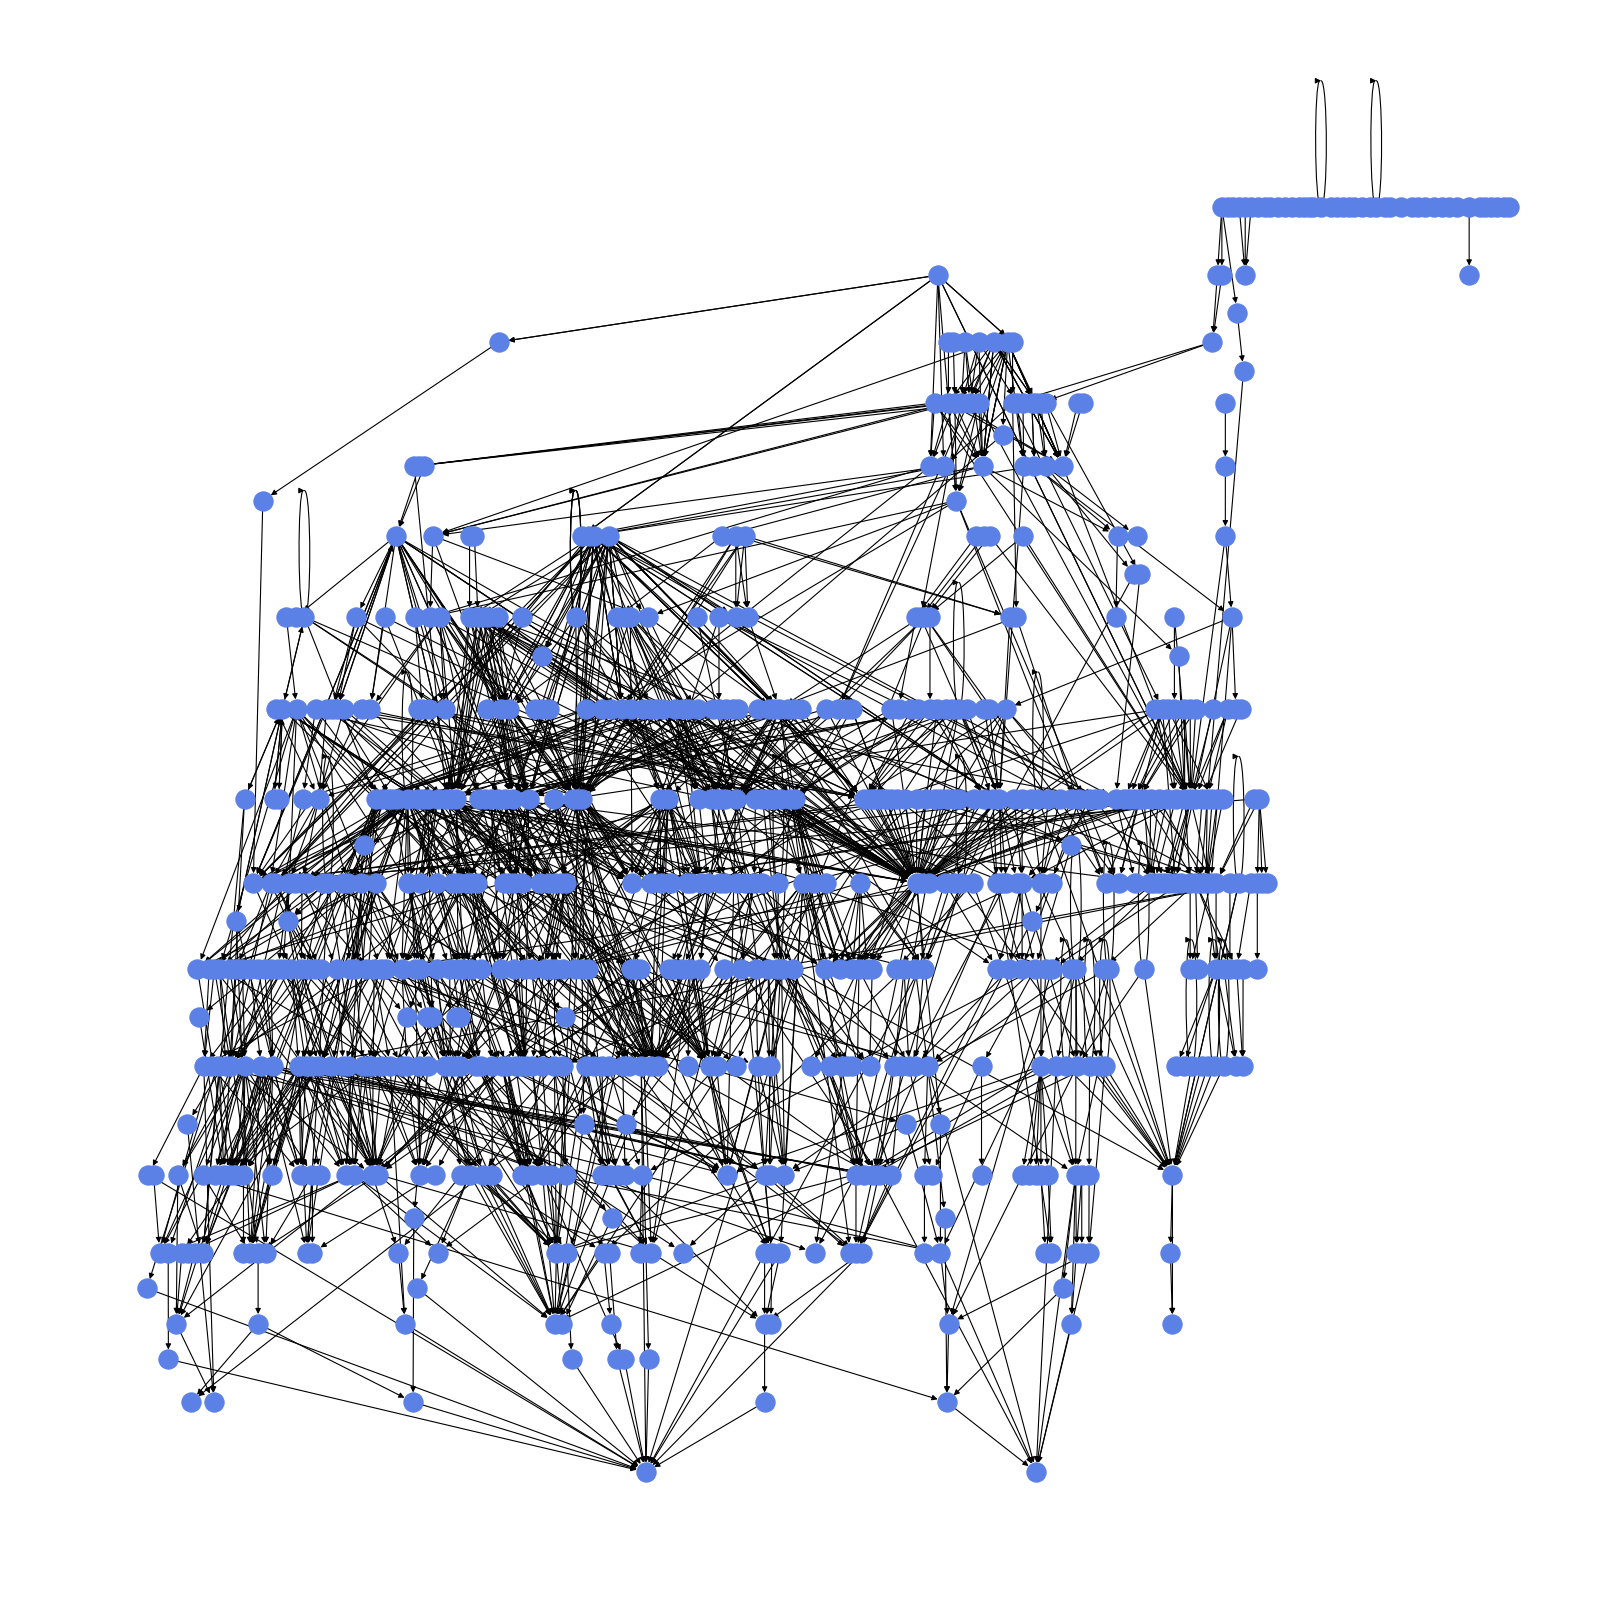

In [23]:
plt.figure(figsize=(20, 20), dpi=80)
nx.draw(full_graph, pos_full, arrows=True, node_color="#5c81e6")
plt.show()

#### Preprocessing

In [24]:
# Remove unstable nodes where dotfile name is same as db measurement
unstable_benchmarks_idx = []
for idx, graph in enumerate(final_graphs):
    if list(ordered_graphs.keys())[idx].rsplit("_", 1)[1] in unstable_benchmarks:
        print("Removing unstable benchmark", list(ordered_graphs.keys())[idx])
        unstable_benchmarks_idx.append(idx)

print(unstable_benchmarks_idx)

Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-compressed-32768
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-compressed-262144
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-1024
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-1
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-compressed-16
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-8
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-16
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-compressed-2
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-2
Removing unstable benchmark 05-28-2023_BenchmarkChecksum-checksum-4
[1, 38, 46, 126, 136, 140, 155, 159, 171, 205]


# Reduction Algorithm

Switched for more stable benchmark
Key error BenchmarkChecksum-checksum-compressed-256 BenchmarkNexts-nextmany__50.000000%
Key error BenchmarkChecksum-checksum-16384 BenchmarkNexts-nextmany__25.000000%
Key error BenchmarkNexts-nextmany__3.125000% BenchmarkNexts-nextmany__25.000000%
Key error BenchmarkGetTestBitSet BenchmarkNexts-nextmany__25.000000%
Switched for more stable benchmark
Key error BenchmarkGetTestBitSet BenchmarkNexts-nextmany__25.000000%
Switched for more stable benchmark
Key error BenchmarkGetTestBitSet BenchmarkNexts-nextmany__25.000000%
Switched for more stable benchmark
Key error BenchmarkNexts-nextmany__0.097656% BenchmarkShortIteratorAdvanceArray-init_size_1_shortIterator_advance
Key error BenchmarkUnionInPlaceCopyOnWrite-4-10-3-10 BenchmarkNexts-nextmany__25.000000%
Key error BenchmarkChecksum-checksum-16384 BenchmarkNexts-nextmany__25.000000%
Key error BenchmarkNexts-nextmany__3.125000% BenchmarkNexts-nextmany__25.000000%
Switched for more stable benchmark
Key err

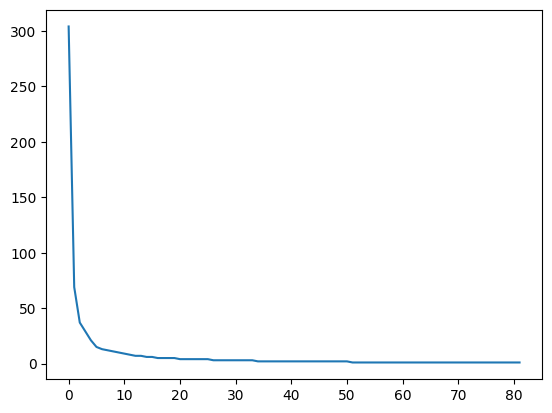

In [26]:
"""Take graphs with highest coverage and remove them from the remaining graphs."""
available_graphs = final_graphs.copy()
reduce_graphs_nodes = []
remaining_graph = full_graph.copy()
coverage_information = {}
iterations = 0
used_graph_idx = []

while len(remaining_graph.nodes()) > 1:
    
    # Find highest coverage within the unused benchmark graphs
    highest_coverage = (0, 0)
    
    for idx, benchmark_graph in enumerate(available_graphs):  

        if (idx in used_graph_idx) or (idx in unstable_benchmarks_idx): #or (idx in failed_benchs_idx):
            continue

        overlap_nodes = np.intersect1d(list(benchmark_graph.nodes()), list(remaining_graph.nodes()))
        overlap = len(overlap_nodes)

        if overlap == highest_coverage[1] and overlap > 0:
            name_curr = list(ordered_graphs.keys())[idx].split("_", 1)[1]
            name_highest = list(ordered_graphs.keys())[highest_coverage[0]].split("_", 1)[1]

            try:
                stability_curr = np.mean(stability_measures[name_curr])
                stability_high = np.mean(stability_measures[name_highest])
            except KeyError:
                print("Key error", name_curr, name_highest)
                continue
                        
            # print(f"Remaining: {len(remaining_graph.nodes())} - Overlap between {idx} and {highest_coverage[0]}: {overlap}, Stabilities: {stability_curr} {stability_high}")
            # Take the more stable benchmark

            if stability_curr < stability_high:
                print("Switched for more stable benchmark")
                highest_coverage = (idx, overlap)
            
        if overlap > highest_coverage[1]:
            highest_coverage = (idx, overlap)
        
        if iterations == 0:
            coverage_information[list(ordered_graphs.keys())[idx]] = overlap

    
    # if iterations % 20  == 0:
    #     plt.figure(figsize=(20, 20), dpi=80)
    #     color_map_full = ['blue' if node in remaining_graph.nodes()  else 'green' for node in full_graph.nodes()]
    #     nx.draw(full_graph, pos_full, with_labels=False, arrows=True, node_color=color_map_full)
    #     plt.show()

    if highest_coverage[1] == 0:
        print(f"Failed to find graph with overlap, Remaining: {len(remaining_graph.nodes())}")
        break
    
    reduce_graphs_nodes.append(highest_coverage)
    
    # remove graph from unused graphs and nodes from remaining graph
    used_graph = available_graphs[highest_coverage[0]].copy()
    used_graph_idx.append(highest_coverage[0])
    remaining_graph.remove_nodes_from(used_graph.nodes())
    iterations += 1

plt.plot([x[1] for x in reduce_graphs_nodes])
plt.show()

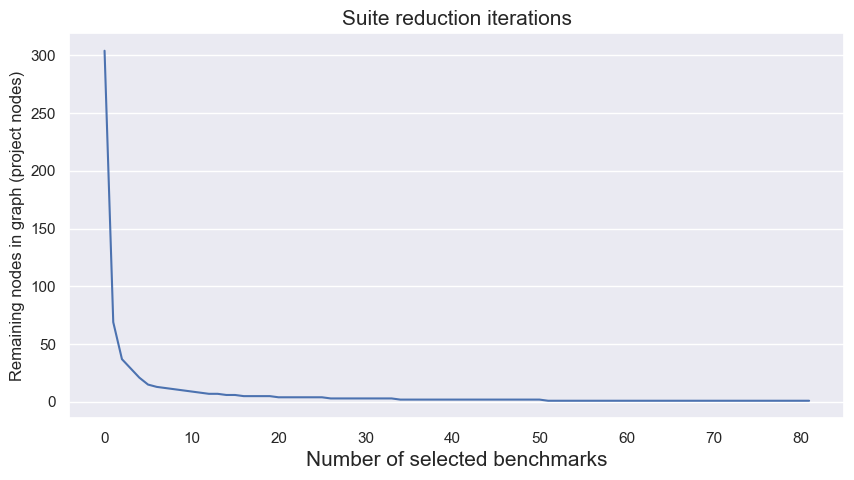

In [67]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Suite reduction iterations", fontsize=15)
plt.plot([x[1] for x in reduce_graphs_nodes])
ax.grid(axis='x', alpha=0.00)


plt.xlabel("Number of selected benchmarks", fontsize=15)
plt.ylabel("Remaining nodes in graph (project nodes)", fontsize=12)
plt.savefig('graphics/roaring_suite_reduction.png', dpi=300, bbox_inches='tight')
plt.show()

# Result Visualization

In [27]:
reduced_suite = [(x[0], list(ordered_graphs.keys())[x[0]].split('_', 1)[1]) for x in reduce_graphs_nodes]

In [28]:
notFound = 0
failed_benchs_idx = []
reduced_idx = [x[0] for x in reduce_graphs_nodes]
stabilities_new = []
stabilities_old = []
for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        stability = np.mean(stability_measures[name])
        stabilities_old.append(stability)
        if idx in reduced_idx:
            stabilities_new.append(stability)
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyError: 05-28-2023_BenchmarkNexts-next__1.562500% -> BenchmarkNexts-next__1.562500%
KeyError: 05-28-2023_BenchmarkNexts-nextmany__50.000000% -> BenchmarkNexts-nextmany__50.000000%
KeyError: 05-28-2023_BenchmarkNexts-nextmany__25.000000% -> BenchmarkNexts-nextmany__25.000000%
KeyError: 05-28-2023_BenchmarkNexts-next__0.097656% -> BenchmarkNexts-next__0.097656%
KeyError: 05-28-2023_BenchmarkNexts-nextmany__3.125000% -> BenchmarkNexts-nextmany__3.125000%
KeyError: 05-28-2023_BenchmarkNexts-next__12.500000% -> BenchmarkNexts-next__12.500000%
KeyError: 05-28-2023_BenchmarkNexts-nextmany__0.012352% -> BenchmarkNexts-nextmany__0.012352%
KeyError: 05-28-2023_BenchmarkNexts-next__0.390625% -> BenchmarkNexts-next__0.390625%
KeyError: 05-28-2023_BenchmarkIteratorAlloc-many_iteration -> BenchmarkIteratorAlloc-many_iteration
KeyError: 05-28-2023_BenchmarkIteratorAlloc-simple_iteration -> BenchmarkIteratorAlloc-simple_iteration
KeyError: 05-28-2023_BenchmarkNextsRLE-next -> BenchmarkNextsRLE-next


In [61]:
print(np.mean(stabilities_new))
print(np.mean(stabilities_old))

0.040956562172007806
0.11004360109428367


In [63]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
sns.set_theme()
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

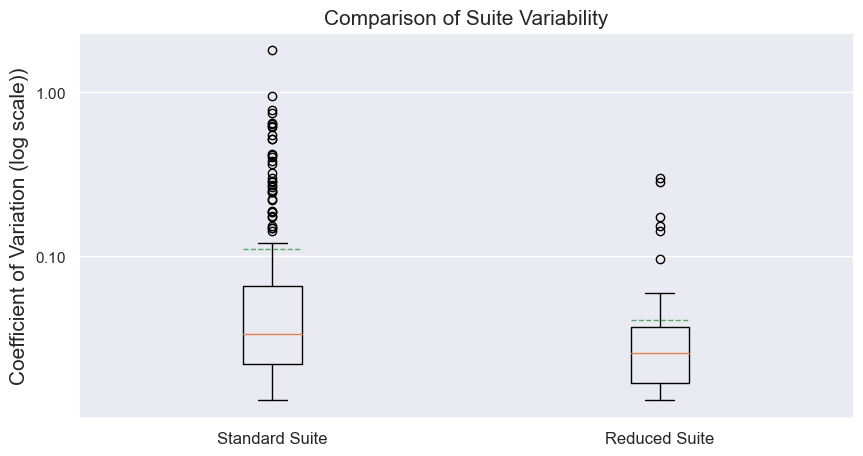

In [69]:
data = [stabilities_old, stabilities_new]

fig, ax = plt.subplots(figsize=(10, 5))
boxplot = ax.boxplot(data, positions=[1, 2], showmeans=True, meanline=True) #, labels=['Standard Suite', 'Reduced Suite'])
ax.set_xticklabels(['Standard Suite', 'Reduced Suite'], fontsize=12)
ax.set_ylabel('Values')
ax.set_title('Comparison of Suite Variability', fontsize=15)
ax.grid(axis='x', alpha=0.00)

plt.ylabel('Coefficient of Variation (log scale))', fontsize=15)
plt.yscale('log')
ax.yaxis.set_major_formatter(formatter) 
plt.savefig('graphics/roaring_variability.png', dpi=300, bbox_inches='tight')
plt.show()

In [73]:
found_changes = []
found_name = []
reduced_idx = [x[0] for x in reduce_graphs_nodes]

for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        if idx in reduced_idx:
            found_changes.append(perf_dict[name])
            found_name.append(name)
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyError: 05-28-2023_BenchmarkSetBitset -> BenchmarkSetBitset
KeyError: 05-28-2023_BenchmarkSerializationSparse -> BenchmarkSerializationSparse
KeyError: 05-28-2023_BenchmarkChecksum-checksum-16384 -> BenchmarkChecksum-checksum-16384
KeyError: 05-28-2023_BenchmarkBitmapReuseWithClear -> BenchmarkBitmapReuseWithClear
KeyError: 05-28-2023_BenchmarkNexts-nextmany__3.125000% -> BenchmarkNexts-nextmany__3.125000%
KeyError: 05-28-2023_BenchmarkGetTestBitSet -> BenchmarkGetTestBitSet
KeyError: 05-28-2023_BenchmarkSerializationDense -> BenchmarkSerializationDense
KeyError: 05-28-2023_BenchmarkPopcount -> BenchmarkPopcount
KeyError: 05-28-2023_BenchmarkMarshalBinary -> BenchmarkMarshalBinary
KeyError: 05-28-2023_BenchmarkInPlaceArrayUnions -> BenchmarkInPlaceArrayUnions
KeyError: 05-28-2023_BenchmarkShortIteratorAdvanceBitmap-init_size_65535_shortIterator_advance -> BenchmarkShortIteratorAdvanceBitmap-init_size_65535_shortIterator_advance
KeyError: 06-06-2023_BenchmarkUnionInPlaceCopyOnWrite-7-

In [74]:
found_name

['BenchmarkIteratorAlloc-simple_iteration_with_alloc',
 'BenchmarkShortIteratorNextBitmap-init_size_1_shortIterator_next',
 'BenchmarkSparseAdvanceRoaring-advance_from_2',
 'BenchmarkIntersectionLargeRoaring',
 'BenchmarkShortIteratorNextArray-init_size_65535_shortIterator_next',
 'BenchmarkAndAny-small-filters_and-first',
 'BenchmarkEqualsClone',
 'BenchmarkAndAny-small-base_AndAny',
 'BenchmarkSparseAdvanceRoaring-advance_from_650',
 'BenchmarkShortIteratorAdvanceArray-init_size_65535_shortIterator_advance',
 'BenchmarkShortIteratorNextArray-init_size_650_shortIterator_next',
 'BenchmarkShortIteratorNextArray-init_size_6500_shortIterator_next',
 'BenchmarkCountBitset',
 'BenchmarkSparseIterateRoaring',
 'BenchmarkIterateRoaring-iterator-compressed',
 'BenchmarkIntersectionBitset']

In [78]:
for idx, x in enumerate(found_name):
    print(perf_dict[x], x)

1.1046288969961071 BenchmarkIteratorAlloc-simple_iteration_with_alloc
32.459088183819375 BenchmarkShortIteratorNextBitmap-init_size_1_shortIterator_next
0.6279441267450059 BenchmarkSparseAdvanceRoaring-advance_from_2
0.43942493654822723 BenchmarkIntersectionLargeRoaring
7.166629171981853 BenchmarkShortIteratorNextArray-init_size_65535_shortIterator_next
1.0697223081207463 BenchmarkAndAny-small-filters_and-first
1.2415037553882513 BenchmarkEqualsClone
0.48760222041892565 BenchmarkAndAny-small-base_AndAny
0.31150759055199595 BenchmarkSparseAdvanceRoaring-advance_from_650
0.3872024630894533 BenchmarkShortIteratorAdvanceArray-init_size_65535_shortIterator_advance
7.782163319016644 BenchmarkShortIteratorNextArray-init_size_650_shortIterator_next
7.682606434363192 BenchmarkShortIteratorNextArray-init_size_6500_shortIterator_next
46.063477362411454 BenchmarkCountBitset
2.2016601525172375 BenchmarkSparseIterateRoaring
5.087931592787287 BenchmarkIterateRoaring-iterator-compressed
5.316658985147

In [66]:
print(len(found_changes))
print(len(perf_dict.keys()))

16
27


In [83]:
not_found = []
for change_b in perf_dict.keys():
    if change_b not in found_name:
        not_found.append(change_b)

print(len(not_found))
not_found

11


['BenchmarkShortIteratorNextBitmap-init_size_650_shortIterator_next',
 'BenchmarkUnionInPlaceCopyOnWrite-4-7-10-10',
 'BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3',
 'BenchmarkIterateRoaring-iterate-compressed',
 'BenchmarkSparseAdvanceRoaring-advance_from_65',
 'BenchmarkShortIteratorNextRuntime-init_size_65535_shortIterator_next',
 'BenchmarkAndAny-small-base_or-first',
 'BenchmarkAndAny-small-filters_AndAny',
 'BenchmarkUnionInPlaceCopyOnWrite-7-4-3-3',
 'BenchmarkIterateRoaring-iterate',
 'BenchmarkShortIteratorNextRuntime-init_size_650_shortIterator_next']

In [121]:
# Check if graphs overlap with reduced suite
newly_found = set()
for change in not_found:
    for idx, graph in enumerate(final_graphs):
        if list(ordered_graphs.keys())[idx].split("_", 1)[1] == change:
            graph = final_graphs[idx]

            highest_overlap = (0, 0)
            for selected in reduced_suite:
                name = selected[1]
                selected_graph = final_graphs[selected[0]]
                overlap_nodes = np.intersect1d(list(graph.nodes()), list(selected_graph.nodes()))

                # calculate percentage of overlap with graph
                overlap_percentage = len(overlap_nodes) / len(graph.nodes())
                if overlap_percentage > 0.8 and overlap_percentage > highest_overlap[1]:
                    highest_overlap = (selected, overlap_percentage)
                
            if highest_overlap[1] > 0:  
                selected = highest_overlap[0]
                name = selected[1]
                selected_graph = final_graphs[selected[0]]

                # calculate missing nodes
                missing_nodes = np.setdiff1d(list(graph.nodes()), list(selected_graph.nodes()))

                if highest_overlap[1] < 1.0 and False:
                    for selected in reduced_suite:
                        name1 = selected[1]
                        selected_graph = final_graphs[selected[0]]
                        overlap_nodes = np.intersect1d(missing_nodes, list(selected_graph.nodes()))

                        # calculate percentage of overlap with graph
                        overlap_percentage = len(overlap_nodes) / len(graph.nodes())
                        if overlap_percentage > 0.5:
                            print(f"Missing nodes: {len(missing_nodes)} - Overlap: {overlap_percentage}")
                        if overlap_percentage == 1.0:
                            print(f"Missing benchmark {change} overlaps with {name} and {name1}")
                            newly_found.add(change)
                else:       
                    print(f"Missing benchmark {change} overlaps with {name}: {highest_overlap[1]} - Missing nodes: {len(missing_nodes)}")
                    newly_found.add(change)

                # Plot graphs
                # plt.figure(figsize=(10, 10), dpi=80)
                # pos_full2 = {k: (v[0] + 100, v[1]) for k, v in pos_full.items()}
                # nx.draw(selected_graph, pos_full, arrows=True, node_color="blue")
                # nx.draw(graph, pos_full2, arrows=True, node_color="red")
                # plt.show()

Missing benchmark BenchmarkShortIteratorNextBitmap-init_size_650_shortIterator_next overlaps with BenchmarkShortIteratorNextArray-init_size_6500_shortIterator_next: 0.8421052631578947 - Missing nodes: 36
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-10 overlaps with BenchmarkUnionInPlaceCopyOnWrite-7-10-3-10: 1.0 - Missing nodes: 0
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 overlaps with BenchmarkUnionInPlaceCopyOnWrite-7-10-3-10: 0.95 - Missing nodes: 1
Missing benchmark BenchmarkIterateRoaring-iterate-compressed overlaps with BenchmarkNexts-nextmany__3.125000%: 0.8486238532110092 - Missing nodes: 33
Missing benchmark BenchmarkSparseAdvanceRoaring-advance_from_65 overlaps with BenchmarkSparseAdvanceRoaring-advance_from_650: 0.8719211822660099 - Missing nodes: 26
Missing benchmark BenchmarkShortIteratorNextRuntime-init_size_65535_shortIterator_next overlaps with BenchmarkShortIteratorAdvanceRuntime-init_size_1_shortIterator_advance: 0.8451327433628318 - Mis

In [108]:
import re

def recalculate_percentages_based_on_seconds(graph):
    # extract seconds x.xxs using regex
    r = re.compile(r"(\d+\.\d+|\d)s")

    total_time = 0
    for node in graph.nodes(data=True):
        try:
            seconds = r.search(node[1]['label']).group(1)
            total_time += float(seconds)
        except AttributeError:
            print(f"There was an error extracting seconds from {node[1]['label']}")
            continue

    # recalculate percentages
    for node in graph.nodes(data=True):
        try:
            seconds = float(r.search(node[1]['label']).group(1))
        except AttributeError:
            print(f"There was an error extracting seconds from {node[1]['label']}")
            continue

        # calculate percentage of total time
        percentage = seconds / total_time * 100
        node[1]['totalPerc'] = percentage


# check if first graph overlaps graph 2 sufficeintly
def calculate_overlap_value(graph1, graph2):

    # Calculate percentages based on total seconds of reduced graph
    recalculate_percentages_based_on_seconds(graph1)
    recalculate_percentages_based_on_seconds(graph2)

    perc = 0
    for node in graph2.nodes(data=True):
        if node[0] in graph1.nodes():
            # print(f"Found {node[1]['label']} with {node[1]['totalPerc']}")
            perc += node[1]['totalPerc']
    return perc / 100

In [124]:
# Check if graphs overlap with reduced suite with new overlap method
matching_graphs = []
newly_found = set()
for change in not_found:
    for idx, graph in enumerate(final_graphs):
        if list(ordered_graphs.keys())[idx].split("_", 1)[1] == change:
            graph = final_graphs[idx]

            highest_overlap = (0, 0)
            for selected in reduced_suite:
                name = selected[1]
                selected_graph = final_graphs[selected[0]]
                overlap_percentage = calculate_overlap_value(selected_graph, graph)

                if overlap_percentage > 0.95 and overlap_percentage > highest_overlap[1]:
                    highest_overlap = (selected, overlap_percentage)
            
            if highest_overlap[1] > 0:  
                selected = highest_overlap[0]
                name = selected[1]
                selected_graph = final_graphs[selected[0]]
            
                print(f"Missing benchmark {change} overlaps with {name}: {highest_overlap[1]}")
                newly_found.add(change)
                matching_graphs.append((selected_graph, graph))

Missing benchmark BenchmarkShortIteratorNextBitmap-init_size_650_shortIterator_next overlaps with BenchmarkShortIteratorNextArray-init_size_65535_shortIterator_next: 0.991461890878805
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-10 overlaps with BenchmarkUnionInPlaceCopyOnWrite-7-10-3-10: 1.0000000000000002
Missing benchmark BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3 overlaps with BenchmarkUnionInPlaceCopyOnWrite-7-10-3-10: 0.9993902439024392
Missing benchmark BenchmarkIterateRoaring-iterate-compressed overlaps with BenchmarkXor: 0.9900910551687215
Missing benchmark BenchmarkSparseAdvanceRoaring-advance_from_65 overlaps with BenchmarkSparseAdvanceRoaring-advance_from_650: 0.9929672707600777
Missing benchmark BenchmarkShortIteratorNextRuntime-init_size_65535_shortIterator_next overlaps with BenchmarkShortIteratorNextArray-init_size_6500_shortIterator_next: 0.9890254609306407
Missing benchmark BenchmarkAndAny-small-base_or-first overlaps with BenchmarkAndAny-small-filters_or-

In [120]:
print(len(newly_found))
newly_found

11


{'BenchmarkAndAny-small-base_or-first',
 'BenchmarkAndAny-small-filters_AndAny',
 'BenchmarkIterateRoaring-iterate',
 'BenchmarkIterateRoaring-iterate-compressed',
 'BenchmarkShortIteratorNextBitmap-init_size_650_shortIterator_next',
 'BenchmarkShortIteratorNextRuntime-init_size_650_shortIterator_next',
 'BenchmarkShortIteratorNextRuntime-init_size_65535_shortIterator_next',
 'BenchmarkSparseAdvanceRoaring-advance_from_65',
 'BenchmarkUnionInPlaceCopyOnWrite-4-7-10-10',
 'BenchmarkUnionInPlaceCopyOnWrite-4-7-10-3',
 'BenchmarkUnionInPlaceCopyOnWrite-7-4-3-3'}

In [117]:
len(not_found) - len(newly_found)

0

# Visualize matches

In [126]:
graphs = matching_graphs[-4]

In [129]:
labeldict1 = labeldict.copy()
# remove all nodes not in test_graph
for key in labeldict:
    if key not in graphs[0].nodes():
        del labeldict1[key]

labeldict2 = labeldict.copy()
# remove all nodes not in test_graph
for key in labeldict:
    if key not in graphs[1].nodes():
        del labeldict2[key]

In [162]:
# how to generate gradient color values based on percentage
sum = 0
colors1 = []
for node in list(graphs[1].nodes(data=True)):
    percentage = node[1]['totalPerc'] / 100
    # percentage = round(percentage, 3)

    sum = sum + percentage

    color = (int(255 * percentage), int(255 * (1 - percentage)), 0)
    color = '#%02x%02x%02x' % color
    if node[0] not in list(graphs[0].nodes()):
        colors1.append("red")
        labeldict2[node[0]] = percentage
    else:
        colors1.append(color)
        labeldict2[node[0]] = ""

    # labeldict2[node[0]] = percentage

print(sum)

0.9999999999999979


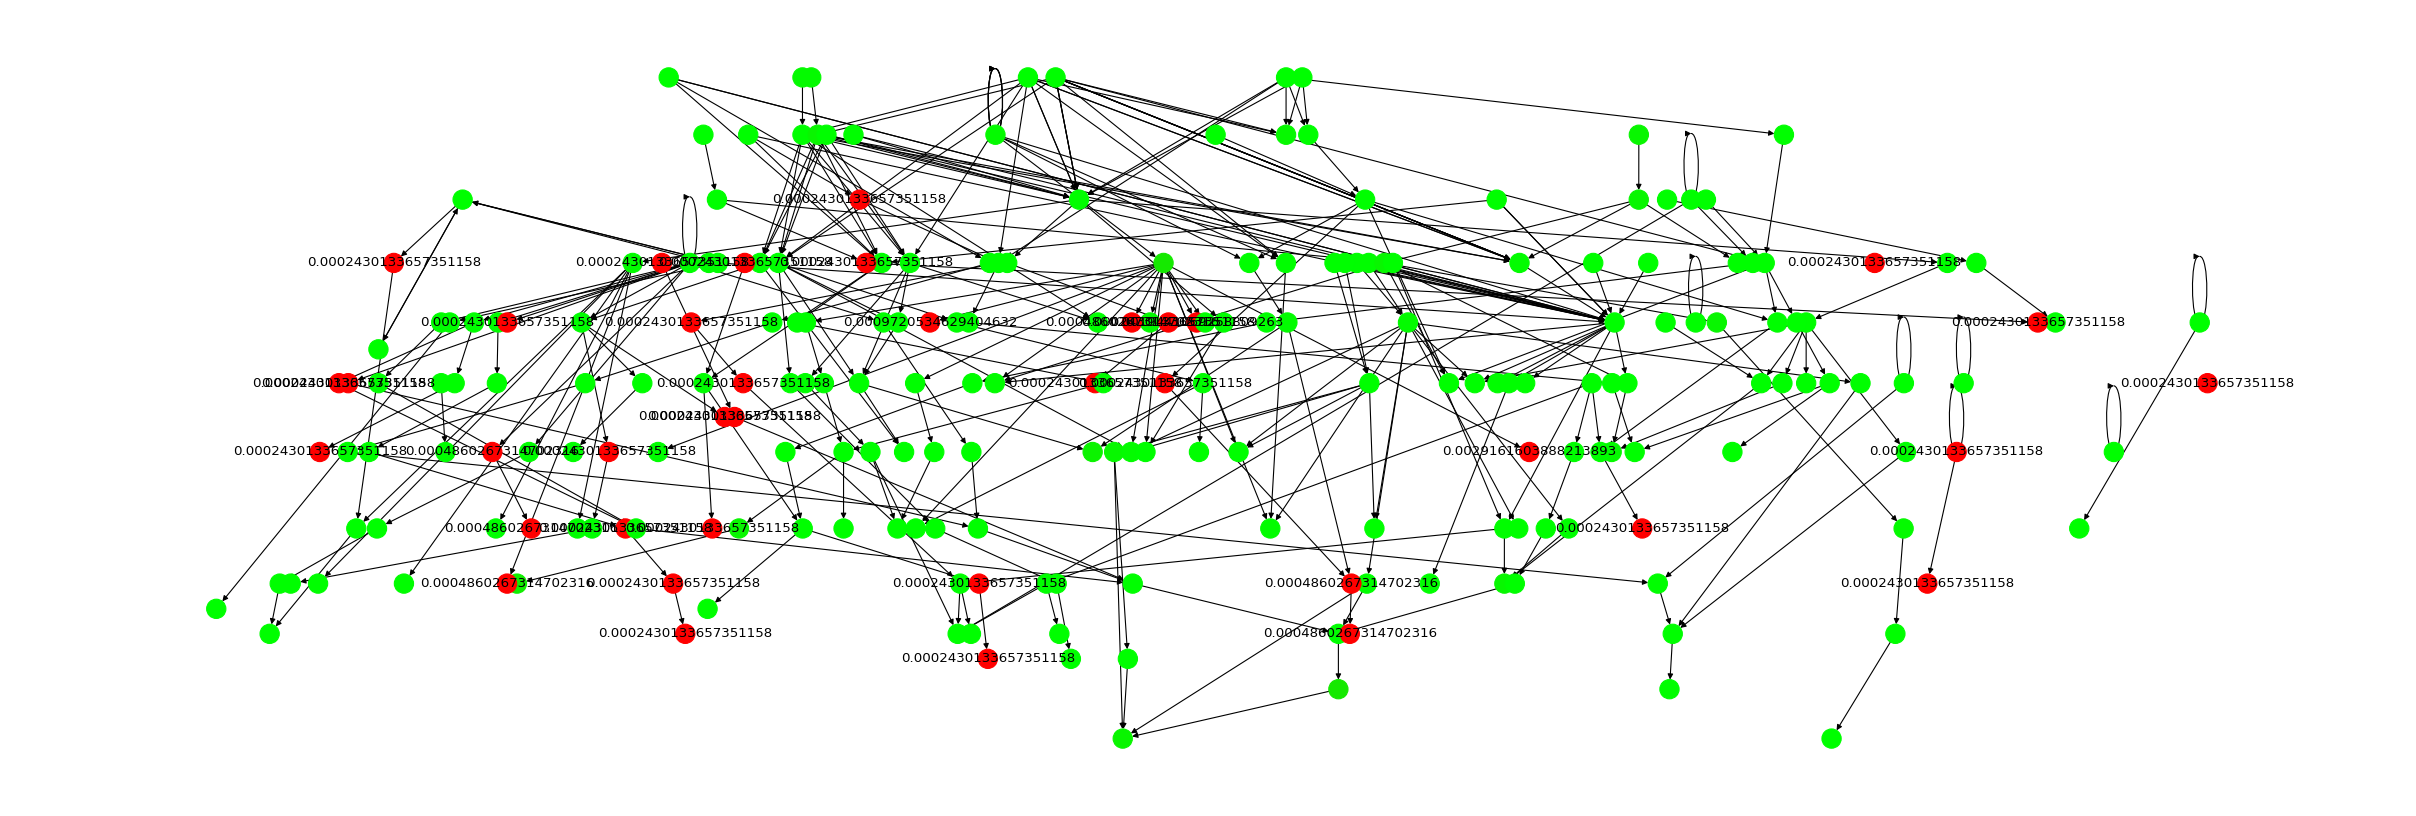

In [163]:
# plot graph with labels
plt.figure(figsize=(30, 10), dpi=80)

# shift pos full
pos_full2 = {k: (v[0] + 200, v[1]) for k, v in pos_full.items()}

# nx.draw(graphs[0], pos_full, arrows=True, node_color="green")
nx.draw(graphs[1], pos_full2, arrows=True, node_color=colors1, labels=labeldict2)
plt.show()

# Time saved

In [164]:
print("Old suite runtime in minutes:", len(final_graphs) * 5 * 3 * 1 / 60)
print("Reduced Suite runtime in minute:", len(reduced_idx) * 5 * 3 * 1 / 60)

Old suite runtime in minutes: 51.75
Reduced Suite runtime in minute: 20.5


[(<networkx.classes.multidigraph.MultiDiGraph at 0x1735f0a10>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x2829b6950>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x28cc5a010>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x176cc4550>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x28cc5a010>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28cc78b90>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x1748e2ad0>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x173579690>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x2873e12d0>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28b9e1010>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x283a37490>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28e0c5b10>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x175c7f090>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28733b610>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x176d144d0>,
  <networkx.classes.multidigraph.MultiDiGraph at